In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the zip file in your Google Drive
zip_file_path = '/content/drive/My Drive/bbox!!!/COCO-BBOX2.zip'  # Update this path with the location of your zip file

# Define the directory to extract the zip file
extract_to_path = '/content/extracted_files'

# Ensure the directory exists
os.makedirs(extract_to_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to: {extract_to_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files extracted to: /content/extracted_files


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import json
import os
from PIL import Image
import cv2

class COCODataset(Dataset):
    def __init__(self, coco_json_path, images_dir, transform=None):
        with open(coco_json_path) as f:
            self.coco_data = json.load(f)
        self.images_dir = images_dir
        self.transform = transform

        # Prepare image and annotation data
        self.image_info = {item['id']: item for item in self.coco_data['images']}
        self.image_ids = list(self.image_info.keys())  # Maintain a list of valid IDs
        self.annotations = {item['image_id']: item for item in self.coco_data['annotations']}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]  # Get the image ID from the mapped list
        img_info = self.image_info[image_id]
        img_path = os.path.join(self.images_dir, img_info['file_name'])

        # Load image
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            raise

        # Get bounding box
        annotation = self.annotations.get(image_id, {})
        bbox = annotation.get('bbox', [0, 0, 1, 1])  # Default bbox if none exists

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(bbox, dtype=torch.float32)

from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

# Define Model
class ResNet18BBoxPredictor(nn.Module):
    def __init__(self):
        super(ResNet18BBoxPredictor, self).__init__()
        # Use weights instead of pretrained=True
        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 4)  # Predict 4 bbox coords

    def forward(self, x):
        return self.backbone(x)

# Training Function
def train_model(model, dataloader, optimizer, criterion, device, epochs=30):
    model.train()
    model.to(device)

    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, bboxes in dataloader:
            images, bboxes = images.to(device), bboxes.to(device)

            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, bboxes)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")


# Main Execution
if __name__ == "__main__":
    # Paths
    COCO_JSON_PATH = "/content/extracted_files/COCO-BBOX2/result.json"
    IMAGES_DIR = "/content/extracted_files/COCO-BBOX2"

    # Transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Dataset and DataLoader
    dataset = COCODataset(COCO_JSON_PATH, IMAGES_DIR, transform=transform)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Model, Optimizer, and Loss
    model = ResNet18BBoxPredictor()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = nn.SmoothL1Loss()

    # Train
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_model(model, dataloader, optimizer, criterion, device, epochs=30)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 220MB/s]


Epoch 1/30, Loss: 290.5673
Epoch 2/30, Loss: 39.8192
Epoch 3/30, Loss: 34.9960
Epoch 4/30, Loss: 24.9330
Epoch 5/30, Loss: 24.0319
Epoch 6/30, Loss: 20.8768
Epoch 7/30, Loss: 21.4306
Epoch 8/30, Loss: 20.8987
Epoch 9/30, Loss: 20.9679
Epoch 10/30, Loss: 20.2370
Epoch 11/30, Loss: 20.5951
Epoch 12/30, Loss: 19.7818
Epoch 13/30, Loss: 19.6396
Epoch 14/30, Loss: 18.4126
Epoch 15/30, Loss: 18.6794
Epoch 16/30, Loss: 19.0408
Epoch 17/30, Loss: 18.7129
Epoch 18/30, Loss: 19.0212
Epoch 19/30, Loss: 17.8039
Epoch 20/30, Loss: 17.8233
Epoch 21/30, Loss: 18.3882
Epoch 22/30, Loss: 17.7469
Epoch 23/30, Loss: 17.3571
Epoch 24/30, Loss: 16.8512
Epoch 25/30, Loss: 17.4904
Epoch 26/30, Loss: 16.6045
Epoch 27/30, Loss: 18.9282
Epoch 28/30, Loss: 17.0111
Epoch 29/30, Loss: 17.1402
Epoch 30/30, Loss: 16.4085


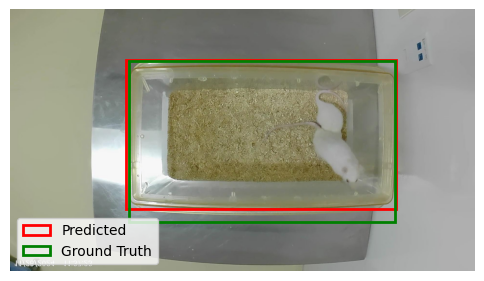

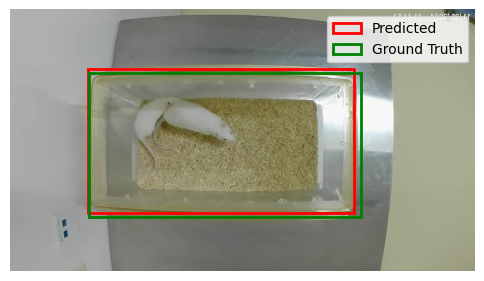

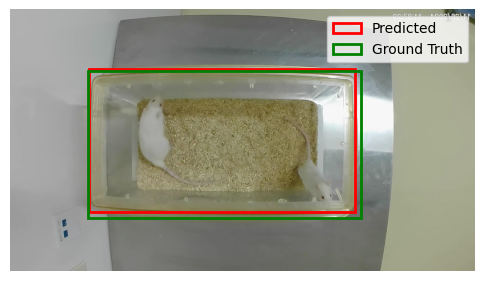

In [ ]:

import random
import matplotlib.pyplot as plt
import numpy as np

def draw_bounding_boxes(model, dataset, images_dir, device, num_samples=3):
    """
    Randomly selects images from a dataset and draws ground truth and predicted bounding boxes.
    """
    # Select random samples
    random_indices = random.sample(range(len(dataset)), num_samples)

    model.eval()
    model.to(device)

    with torch.no_grad():
        for idx in random_indices:
            image, true_bbox = dataset[idx]
            image = image.unsqueeze(0).to(device)  # Add batch dimension

            # Predict bounding box
            pred_bbox = model(image).cpu().squeeze(0).numpy()
            true_bbox = true_bbox.numpy()

            # Load original image (unnormalized for display)
            img_info = dataset.image_info[dataset.image_ids[idx]]
            img_path = os.path.join(images_dir, img_info['file_name'])
            original_image = np.array(Image.open(img_path).convert("RGB"))

            # Draw bounding boxes on the image
            draw_image_with_boxes(original_image, pred_bbox, true_bbox)

def draw_image_with_boxes(image, pred_bbox, true_bbox):
    """
    Draws predicted and ground truth bounding boxes on the image.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Predicted bounding box (red)
    plt.gca().add_patch(
        plt.Rectangle(
            (pred_bbox[0], pred_bbox[1]),
            pred_bbox[2],
            pred_bbox[3],
            fill=False,
            edgecolor="red",
            linewidth=2,
            label="Predicted"
        )
    )

    # Ground truth bounding box (green)
    plt.gca().add_patch(
        plt.Rectangle(
            (true_bbox[0], true_bbox[1]),
            true_bbox[2],
            true_bbox[3],
            fill=False,
            edgecolor="green",
            linewidth=2,
            label="Ground Truth"
        )
    )

    # Add legend
    plt.legend(["Predicted", "Ground Truth"])
    plt.axis("off")
    plt.show()

draw_bounding_boxes(model, dataset, IMAGES_DIR, device)


In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "resnet18_bbox_predictor_checkpoint.pth")


Predicted BBox: (475, 244, 1123, 609)


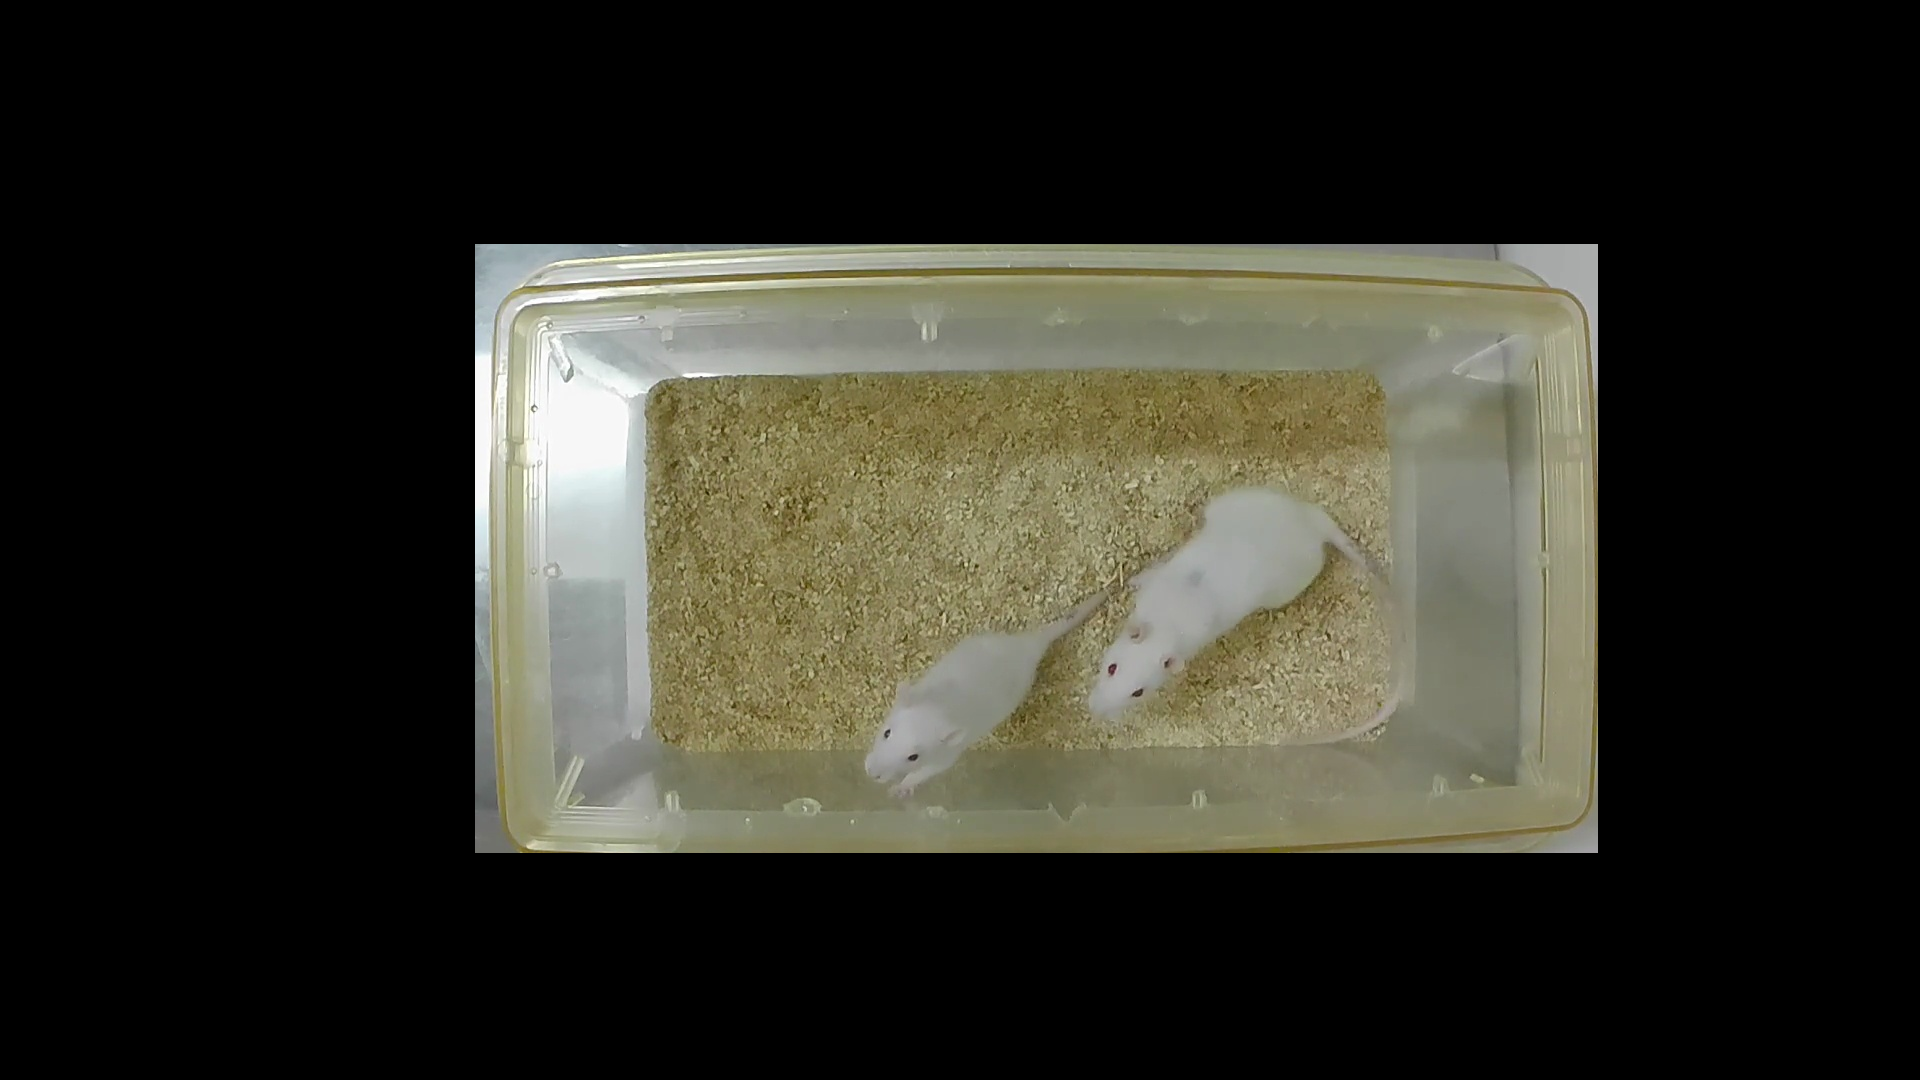

TypeError: 'NoneType' object is not callable

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow

def predict_and_mask(model, image_path, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Predict bounding box
    model.eval()
    with torch.no_grad():
        pred_bbox = model(input_image).squeeze().cpu().numpy()  # Remove batch and move to CPU

    # Convert bbox to integers
    x, y, w, h = map(int, pred_bbox)

    # Load the original image using cv2 for masking
    image_cv2 = cv2.imread(image_path)
    if image_cv2 is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Create a black mask
    mask = np.zeros_like(image_cv2)

    # Define ROI and copy it onto the mask
    roi = image_cv2[y:y+h, x:x+w]
    mask[y:y+h, x:x+w] = roi

    # Return the masked image
    return mask, (x, y, w, h)


masked_image, bbox = predict_and_mask(model, '/content/extracted_files/COCO-BBOX2/images/002090e3-frame_05363.jpg', transform, device)

# Display the result
print(f"Predicted BBox: {bbox}")
cv2_imshow(masked_image) ("Masked Image", masked_image)
